# Advanced PCOS Prediction — Enhanced Jupyter Notebook

> This notebook is a drop-in, production-oriented, end-to-end pipeline for building a robust PCOS screening model using ensemble methods, sound validation, interpretability, and deployment-ready artifacts.

---

## Table of contents

1. Project overview
2. Setup & imports
3. Data loading & quick checks
4. Exploratory Data Analysis (EDA)
5. Feature engineering
6. Preprocessing pipelines (ColumnTransformer + Pipeline)
7. Modeling: baseline models
8. Hyperparameter tuning (RandomizedSearchCV / Optuna)
9. Handling imbalance (SMOTE variants & class weights)
10. Advanced ensembling: stacking with cross-validated meta-features
11. Model evaluation & calibration
12. Interpretability: SHAP explanations
13. Save & export pipeline
14. Small Streamlit demo for prediction
15. Reproducibility & experiment tracking
16. Appendix: unit tests & utilities

---

## 1. Project overview

- **Goal:** Build a reliable classifier that predicts PCOS (binary) from clinical and demographic features.
- **Deliverables:** Clean notebook with EDA, reproducible preprocessing pipeline, tuned models, a stacking ensemble, model explanations (SHAP), a saved artifact (`joblib`), and a tiny Streamlit app for demoing user input predictions.
- **Evaluation focus:** AUC-ROC, precision, recall (sensitivity), and calibration. In screening tasks, prioritize recall while controlling false positives.

---

## 2. Setup & imports


In [51]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import json
import os

# Scikit-learn
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, precision_recall_curve,
                             roc_curve, accuracy_score, brier_score_loss)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Calibration & interpretability
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Optional: experiment tracking
# import mlflow


# Utility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

> If `xgboost`, `imblearn`, or `shap` are not installed, add them to your `requirements.txt`:
>
> `xgboost imbalanced-learn shap mlflow streamlit`.

---

## 3. Data loading & quick checks


In [52]:
# Replace this path with your dataset path
df1 = pd.read_csv(r"C:\Users\HP\Downloads\PCOS Dataset\LRwithinfert 1.csv")
df2 = pd.read_csv(r"C:\Users\HP\Downloads\PCOS Dataset\LRwithout_inferti 2.csv")
#df2.drop(['PCOS (Y/N)'])
df = pd.concat([df1, df2], ignore_index=True)

# Drop irrelevant column
df.drop(columns=["Unnamed: 44"], inplace=True, errors="ignore")

# Quick shape and head
print('rows,cols:', df.shape)
df.head()

# Target assumptions
# Assume there's a binary column 'PCOS(Yes/No)' or 'PCOS' encoded 0/1; adapt accordingly
if 'PCOS' in df.columns:
    target_col = 'PCOS'
elif 'PCOS (Y/N)' in df.columns:
    target_col = 'PCOS (Y/N)'
else:
    raise ValueError('Please set the correct target column name')

# Check class balance
print(df[target_col].value_counts(dropna=False))

# Save a copy
df_original = df.copy()

rows,cols: (1082, 44)
PCOS (Y/N)
0    728
1    354
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

**Key checks to include:**
- Missing values heatmap
- Distribution plots for numeric features
- Boxplots grouped by target
- Correlation matrix and hierarchical clustering
- Pairplots for top correlated features

---

C:\Users\HP\AppData\Local\Temp\ipykernel_3560\3826909799.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False)
C:\Users\HP\AppData\Local\Temp\ipykernel_3560\3826909799.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


PCOS (Y/N)              1.000000
Follicle No. (R)        0.648327
Follicle No. (L)        0.603346
Skin darkening (Y/N)    0.475733
hair growth(Y/N)        0.464667
Weight gain(Y/N)        0.441047
Cycle(R/I)              0.401644
Fast food (Y/N)         0.377933
Pimples(Y/N)            0.286077
Weight (Kg)             0.211938
Cycle length(days)      0.178480
Hair loss(Y/N)          0.172879
 Age (yrs)              0.168513
Waist(inch)             0.164598
Hip(inch)               0.162297
Name: PCOS (Y/N), dtype: float64


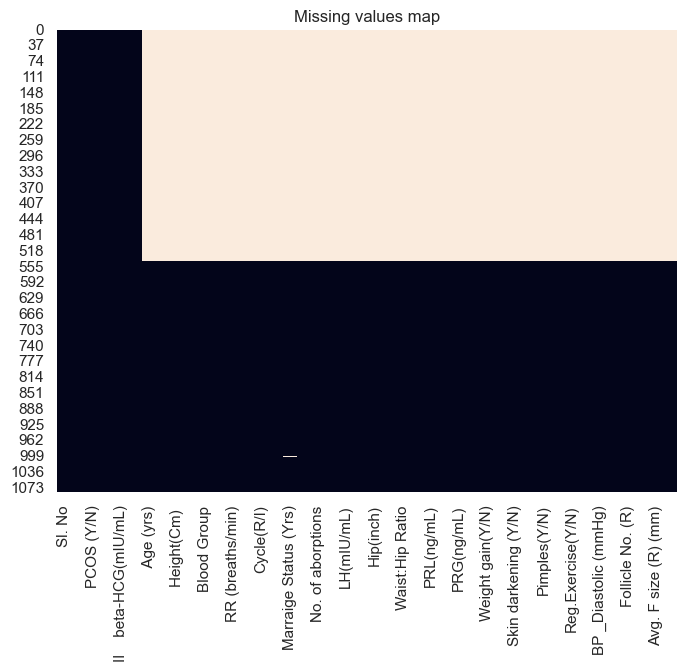

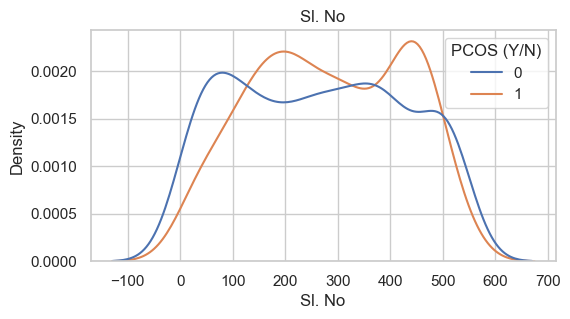

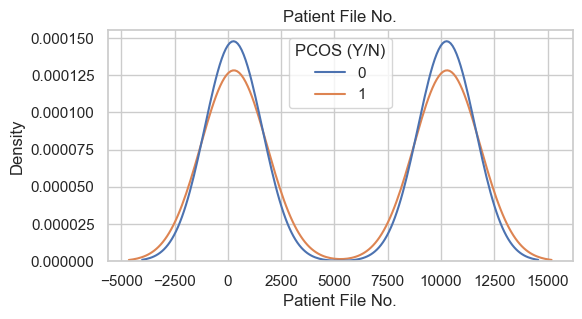

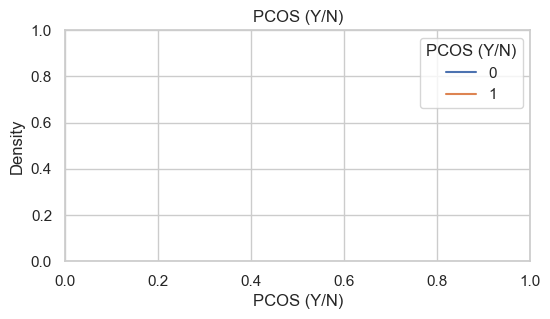

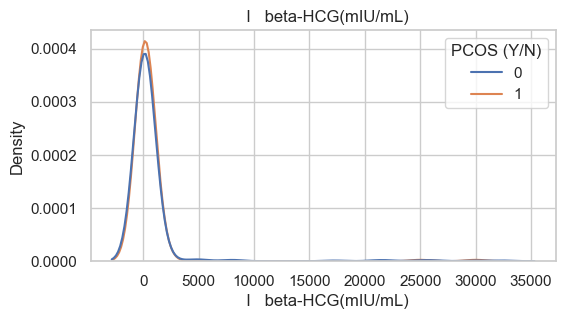

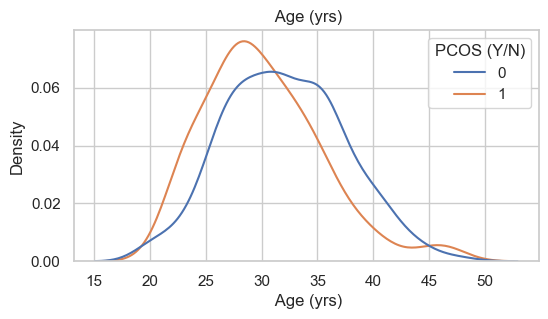

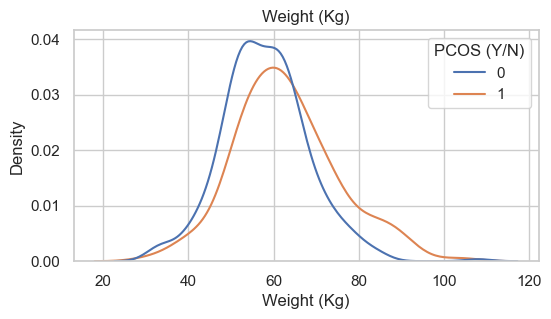

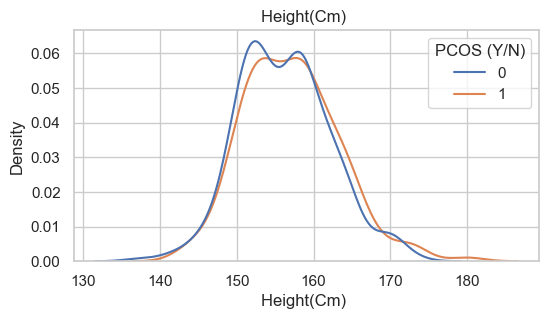

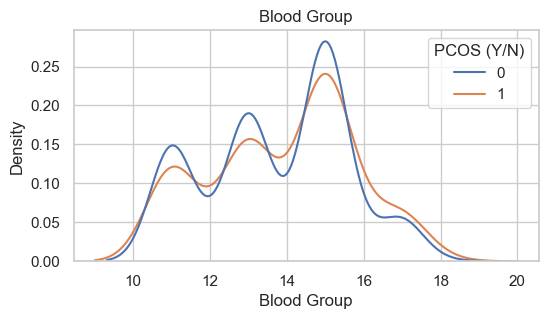

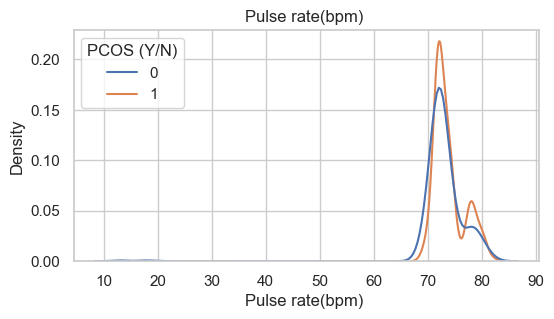

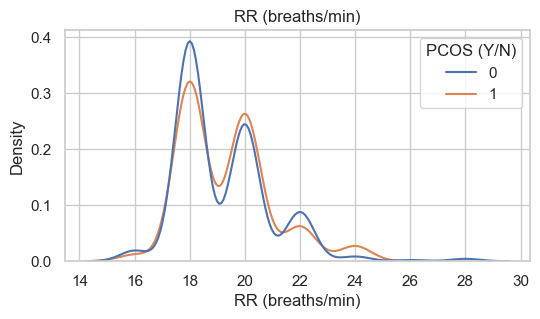

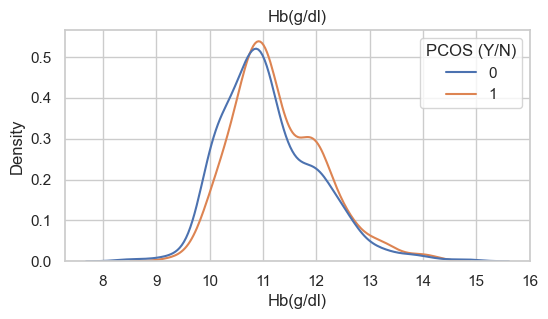

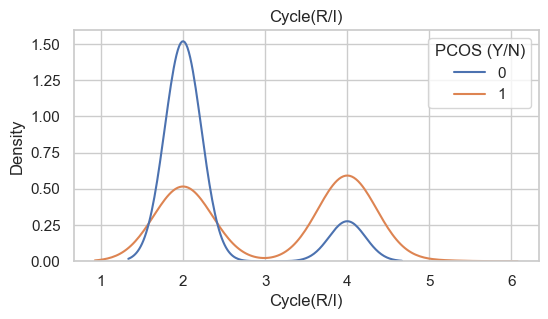

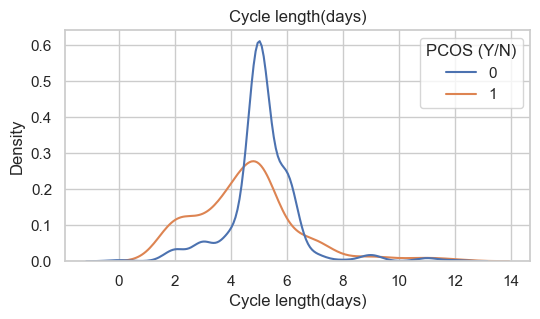

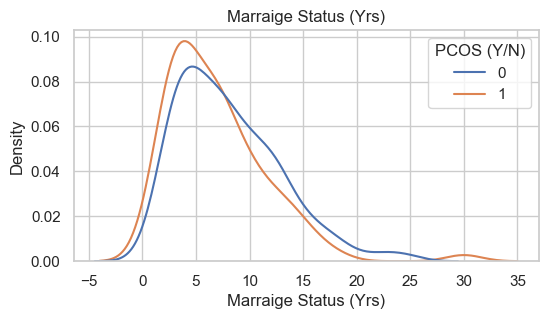

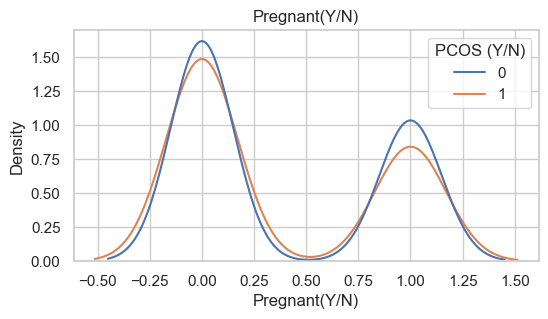

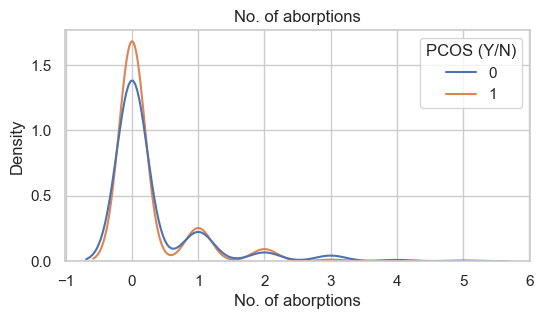

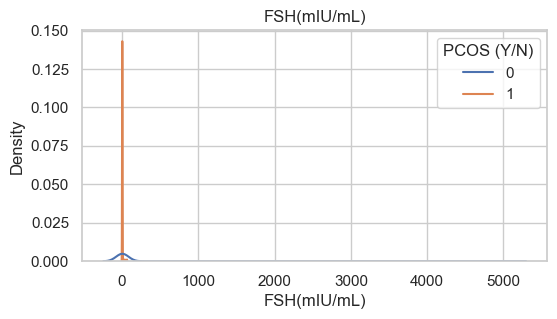

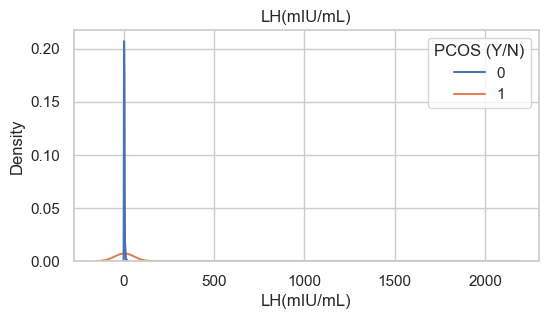

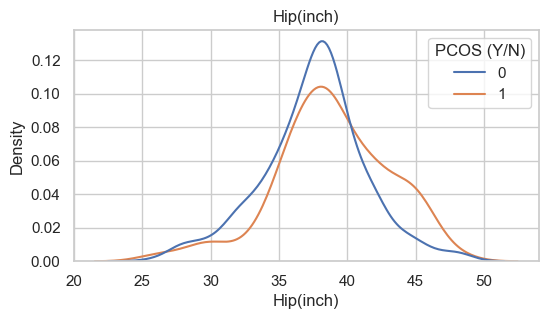

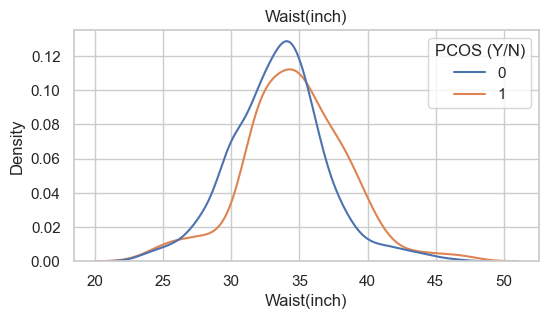

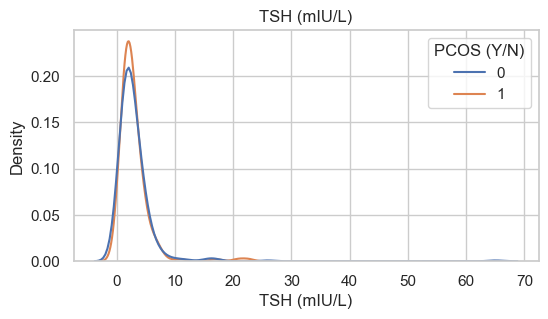

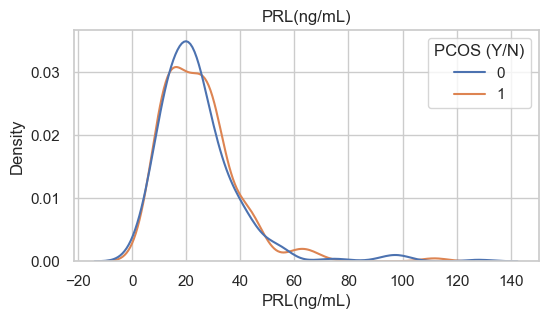

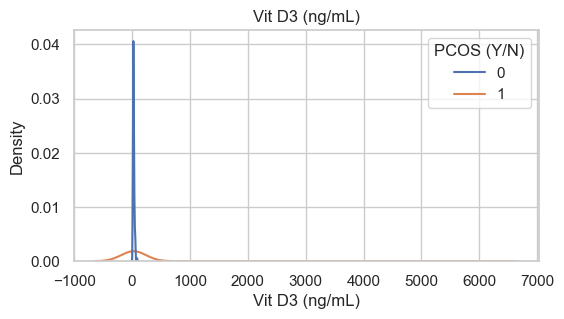

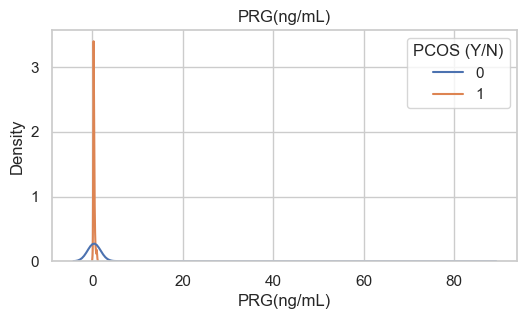

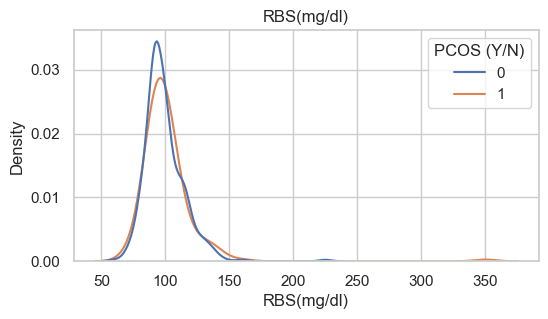

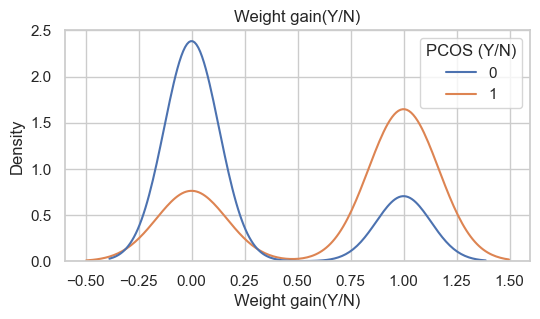

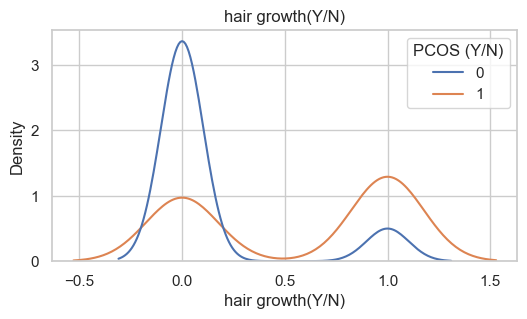

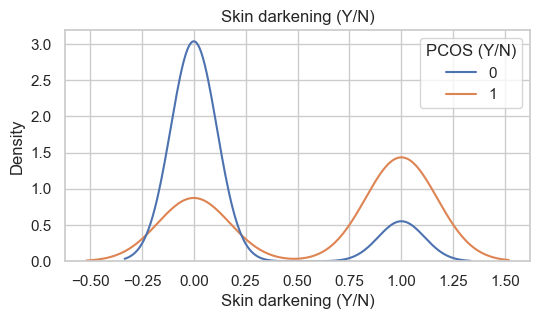

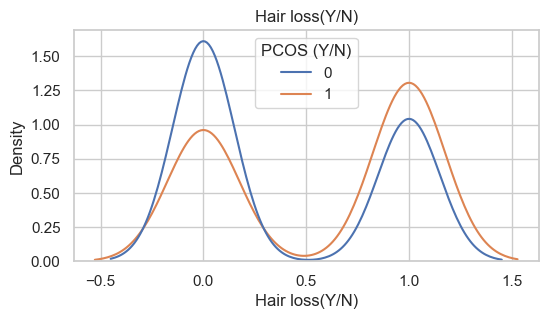

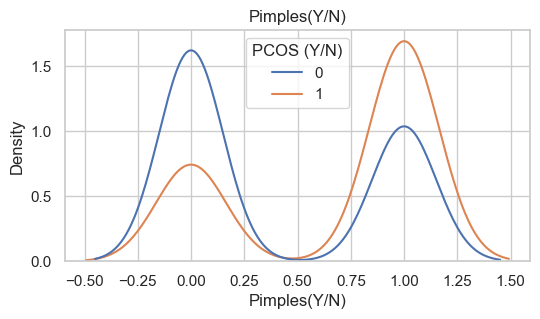

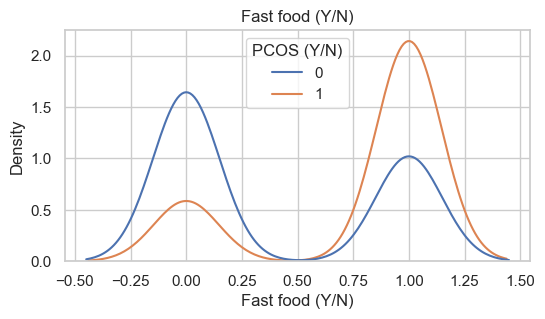

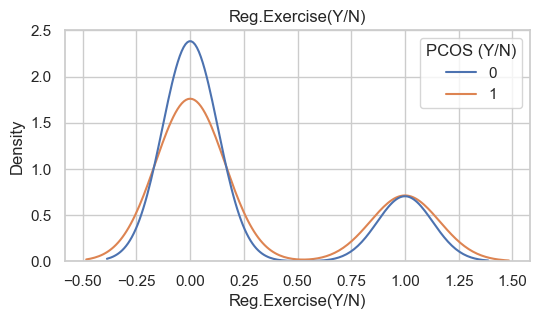

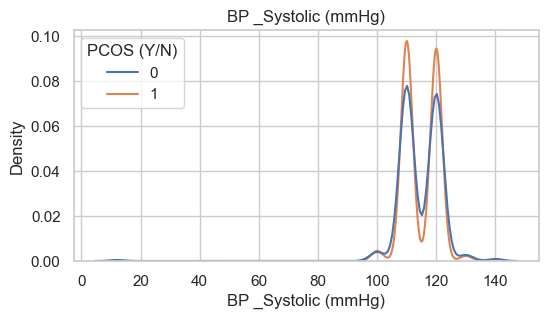

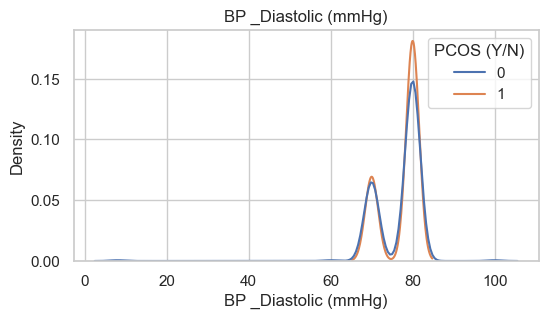

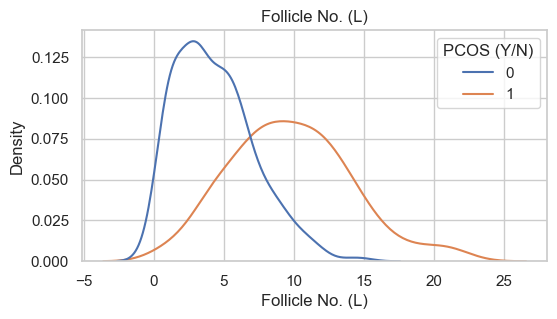

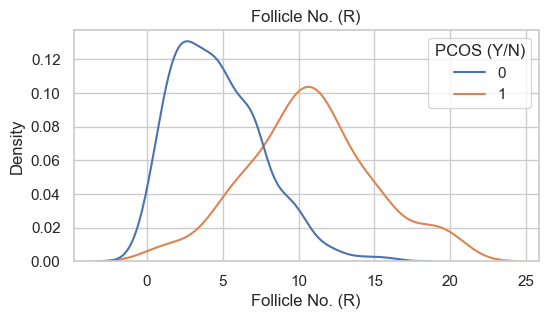

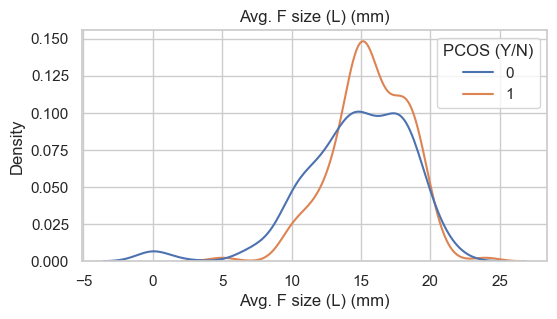

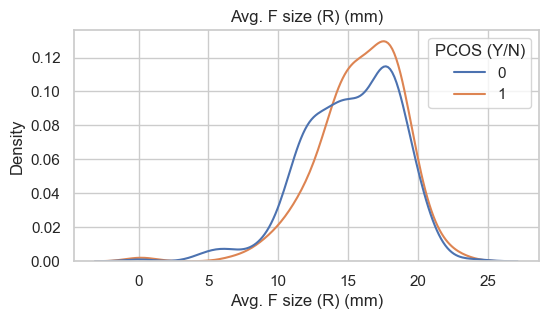

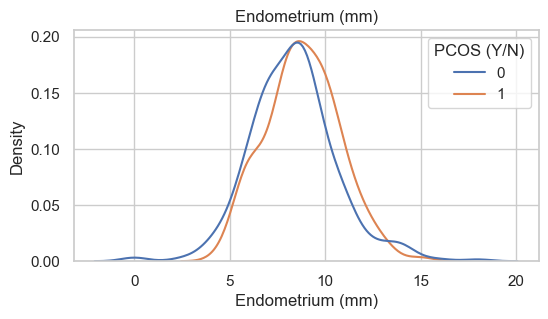

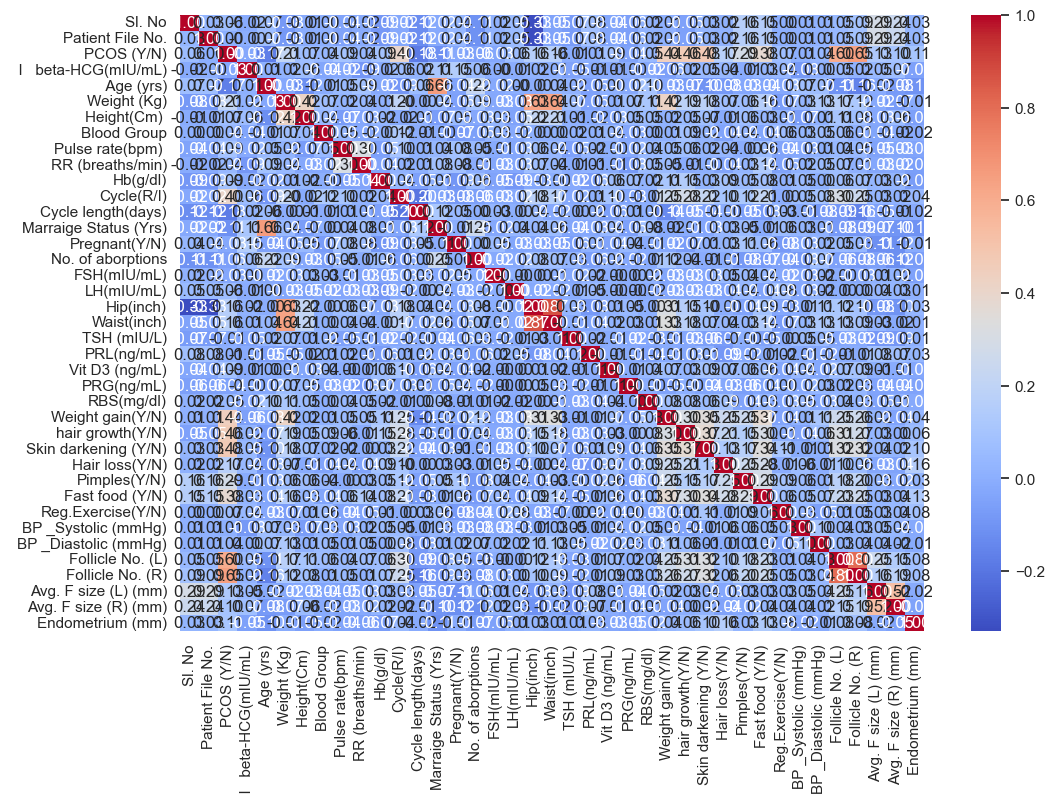

In [53]:
import seaborn as sns
sns.set(style='whitegrid')

# Missing values
plt.figure(figsize=(8,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing values map')

# Numeric distribution example
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False)
    plt.title(col)

# Correlation
corr = df[numeric_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

# Top correlated with target
corr_with_target = corr[target_col].abs().sort_values(ascending=False)
print(corr_with_target.head(15))

## 5. Feature engineering

- Create BMI from weight/height if needed.
- Hormonal ratios (e.g., FSH/LH) if both available.
- Binarize or bucket continuous features where clinically meaningful.

---

In [54]:
# Example: BMI
if 'Weight' in df.columns and 'Height' in df.columns:
    # assume height is cm
    df['BMI'] = df['Weight'] / ((df['Height']/100.0)**2)

# Example: FSH/LH
if 'FSH' in df.columns and 'LH' in df.columns:
    df['FSH_LH_ratio'] = df['FSH'] / (df['LH'] + 1e-6)

# One-hot small categorical features
# df = pd.get_dummies(df, columns=['SomeCat'], drop_first=True)

---

## 6. Preprocessing pipelines

Use `ColumnTransformer` to keep things reproducible.

In [55]:
# Identify column types (adjust heuristics for your dataset)
numeric_features = [c for c in df.columns if df[c].dtype in ['int64','float64'] and c!=target_col]
cat_features = [c for c in df.columns if df[c].dtype=='object' or df[c].dtype.name=='category']

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
])

# Example final pipeline placeholder (to be used with ImbPipeline if using SMOTE)
base_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_clf)
])

> Note: If you use `SMOTE`, move it into an `imblearn.pipeline.Pipeline` AFTER the preprocessor, or better, before a classifier when features are numeric. Alternatively, use pipelines that handle sampling correctly.

---

## 7. Modeling: baseline models

Train quick baseline models with stratified CV.

In [56]:
# List of mixed-type columns
mixed_cols = [
    "II    beta-HCG(mIU/mL)",
    "BMI",
    "FSH/LH",
    "Waist:Hip Ratio"
]

# Replace placeholders ('?', 'NA', etc.) with NaN and convert to numeric
for col in mixed_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [57]:
models = {
    'logreg': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    'mlp': MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}
for name, clf in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    scores = cross_val_score(pipe, df.drop(columns=[target_col]), df[target_col], cv=cv, scoring='roc_auc')
    results[name] = scores
    print(name, 'AUC mean±std:', scores.mean(), scores.std())

logreg AUC mean±std: 0.8827367511635709 0.03000116897326205
rf AUC mean±std: 0.8197131062235483 0.018417945155920913


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:07] WARNING: C:\actions-runner\_w

xgb AUC mean±std: 0.852034322134983 0.017244013889379926
mlp AUC mean±std: 0.9064529738658689 0.019706317053313698


---

## 8. Hyperparameter tuning

Use `RandomizedSearchCV` or Optuna for XGBoost and RandomForest. Example for RandomizedSearchCV on RandomForest:

In [58]:
from scipy.stats import randint as sp_randint

param_dist = {
    'clf__n_estimators': sp_randint(100, 800),
    'clf__max_depth': sp_randint(3, 30),
    'clf__min_samples_split': sp_randint(2, 20),
}

rf_pipe = Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])
rs = RandomizedSearchCV(rf_pipe, param_dist, n_iter=30, cv=cv, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1)
rs.fit(df.drop(columns=[target_col]), df[target_col])
print('Best params', rs.best_params_)
print('Best CV AUC:', rs.best_score_)

Best params {'clf__max_depth': 22, 'clf__min_samples_split': 4, 'clf__n_estimators': 584}
Best CV AUC: 0.8553595450834435


> For faster and more powerful search, consider Optuna and pass a custom objective that performs cross-validation and returns AUC.

---

## 9. Handling imbalance

In [59]:
# Example pipeline with SMOTE (apply after preprocessing; ensure numeric inputs)
smote = SMOTE(random_state=RANDOM_STATE)
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
])

scores = cross_val_score(imb_pipeline, df.drop(columns=[target_col]), df[target_col], cv=cv, scoring='roc_auc')
print('SMOTE + XGB AUC:', scores.mean(), scores.std())

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:16] WARNING: C:\actions-runner\_w

SMOTE + XGB AUC: 0.8549215843003225 0.014549941126093159


Compare SMOTE variants and `class_weight='balanced'` strategies.

---

## 10. Advanced ensembling: stacking

Use cross-validated stacked predictions to avoid leakage. Example using `StackingClassifier`:


In [60]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)),
    ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1, passthrough=False)
stack_pipe = Pipeline([('preprocessor', preprocessor), ('clf', stack)])

scores = cross_val_score(stack_pipe, df.drop(columns=[target_col]), df[target_col], cv=cv, scoring='roc_auc')
print('Stacking AUC mean±std:', scores.mean(), scores.std())

# Fit on full train set
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target_col]), df[target_col], stratify=df[target_col], test_size=0.2, random_state=RANDOM_STATE)
stack_pipe.fit(X_train, y_train)
y_pred = stack_pipe.predict(X_test)
y_proba = stack_pipe.predict_proba(X_test)[:,1]
print('Test AUC:', roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Stacking AUC mean±std: 0.8853316117774194 0.01802321462244343
Test AUC: 0.8894462666409416
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       146
           1       0.80      0.61      0.69        71

    accuracy                           0.82       217
   macro avg       0.81      0.77      0.78       217
weighted avg       0.82      0.82      0.81       217



---

## 11. Model evaluation & calibration

chosen threshold (0.23631137407107264, 0.5871559633027523, 0.9014084507042254)


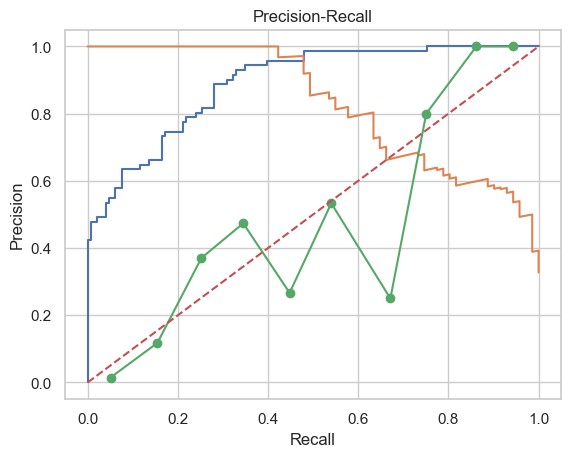

In [61]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC')

# Precision-Recall
precision, recall, thr = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')

# Calibration
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--')

# Threshold tuning (choose threshold to maximize recall given acceptable precision)
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, y_proba)
# Example: pick threshold that gives recall >= 0.90 (if possible)
candidates = [(t, pp, rr) for t, pp, rr in zip(np.append(thresholds,1), p, r) if rr>=0.90]
if candidates:
    chosen = sorted(candidates, key=lambda x: -x[1])[0]
    print('chosen threshold', chosen)

---

## 12. Save & export pipeline

In [62]:
# Save the full pipeline
artifact_path = r'C:\Users\HP\Downloads\pcos_final_pipeline.joblib'
joblib.dump(stack_pipe, artifact_path)
print('Saved pipeline to', artifact_path)

# Example usage
loaded = joblib.load(artifact_path)
# predict using loaded.predict(df_single)

Saved pipeline to C:\Users\HP\Downloads\pcos_final_pipeline.joblib


---
## 13. Small Streamlit demo

Create `app.py` for quick demo:

In [63]:
# app.py (Streamlit)
import streamlit as st
import joblib
import pandas as pd

pipe = joblib.load(r'C:\Users\HP\Downloads\pcos_final_pipeline.joblib')

st.title('PCOS Screening Demo')
# build inputs dynamically based on pipeline features
# Example: numeric inputs
age = st.number_input('Age', min_value=10, max_value=80, value=25)
# ... add more fields matching your dataset

if st.button('Predict'):
    X = pd.DataFrame([{ 'Age': age }])
    pred_prob = pipe.predict_proba(X)[:,1][0]
    st.write('PCOS probability: {:.2f}%'.format(pred_prob*100))

2025-09-06 00:07:41.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.797 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 00:07:41.809 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Run locally: `streamlit run app.py`




---

# **THE END**

### *Author* : Amreeta Surana